In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %qtconsole
from IPython.display import display, HTML

# initiate settings

In [2]:
import pandas as pd
import os
import numpy as np
import pylab as plt
from pylab import show
import re
from utils import vector_dist, digitize, rename_labels, \
                  plot_3d_mean_std_pivot_table, plot_3d_pivot_table, plot_4_2d_pt, \
                  plot_4_4_cdfs, plot_moving_window, plot_16_cdfs, rollBy, \
                  roll_window_regardless_values
from scipy.stats import ks_2samp

BASE_DIR = r"D:\Users\Mojo\Google Drive\project - astrophysics\raw_data"
pd.set_option('display.width', 1000)

# import stars and planets table

In [3]:
#### stars table ###
stars_path = os.path.join(BASE_DIR, "stars.xlsx")
stars_raw = pd.read_excel(stars_path)
# clean stars with not Age or Teff
stars_raw = stars_raw[stars_raw.Age.notnull()]
stars_raw = stars_raw[stars_raw.Teff.notnull()]
print "Stars:", stars_raw.shape

### planets table ###
planets_path = os.path.join(BASE_DIR, "planets.xlsx")
planets = pd.read_excel(planets_path)
p_raw = planets
num_rows = p_raw.shape[0]
print "Read {:d} planets from file {:s}".format(num_rows, "planets.xlsx")

Stars: (34886, 12)
Read 4707 planets from file planets.xlsx


# cleaning, binning (Teff)

In [18]:
def dffilter(df, condition, num_rows, condition_text=""):
    df = df[condition]
    print "Dropped {:d} rows {:s}".format(num_rows - df.shape[0], condition_text)
    num_rows = df.shape[0]
    print "Num rows: {:d}".format(num_rows)
    return df, num_rows

print "Cleaning planets..."
# only deal with planets with age and temperature
p_raw, num_rows = dffilter(p_raw, p_raw.Age.notnull() & p_raw.Teff.notnull(), 
                           num_rows, "without Age or Teff")
# remove those planets with uncertain temperature (temp-diff < 400K)
p_raw, num_rows = dffilter(p_raw, p_raw.teff_34030_8826_diff.fillna(0) < 400,
                           num_rows, "with teff_34030_8826_diff > 400 (undefined temperature)")
# remove planets with wrong period
p_raw, num_rows = dffilter(p_raw, p_raw.koi_period < 5000, 
                           num_rows, "with koi_period > 5000 days")
# remove planets with huge planetary-radius
p_raw, num_rows = dffilter(p_raw, p_raw.koi_prad < 15, 
                           num_rows, "with koi_prad > 15")


###################################################################
#               Filter planets further than 30days                #
###################################################################
p_raw, num_rows = dffilter(p_raw, p_raw.koi_period < 30, 
                           num_rows, "with koi_prad > 15")

# the statistics become really small anyways for planets older than 5000Myr
p_raw, num_rows = dffilter(p_raw, p_raw.Age < 5000, 
                           num_rows, "with Age > 5000Myr")


stars = stars_raw
p = p_raw

###################################################################
#          Bin systems according to temperatures                  #
###################################################################
systems = p[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
print "Systems num:", systems.shape[0]
teff_categories, teff_qbins = pd.qcut(systems.Teff.values, 4, retbins=True)



Cleaning planets...
Dropped 0 rows without Age or Teff
Num rows: 965
Dropped 0 rows with teff_34030_8826_diff > 400 (undefined temperature)
Num rows: 965
Dropped 0 rows with koi_period > 5000 days
Num rows: 965
Dropped 0 rows with koi_prad > 15
Num rows: 965
Dropped 0 rows with koi_prad > 15
Num rows: 965
Dropped 28 rows with Age > 5000Myr
Num rows: 937
Systems num: 697


# Define dataframes (period <> 7)

In [19]:
# Based on the above results, especially the one frequency charts,
# the main conclusion is that the frequency of planets close to the star increases with age.
# CHECK WITH HAGAI: That might lead to a model that with time, planets get closer to the star
# because of angular-momentum transfer to the star. That should only occur with planets close enough to the star.
# If this is true, we would expect to see a non-increasing frequency with planets farther from the star

koi_period_threshold = 7

# define df for planets smaller-bigger than threshold
pg = p[p.koi_period > koi_period_threshold]
pl = p[p.koi_period < koi_period_threshold]

# define systems-df for each planets-df
systems_g = pg[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
systems_g['multiplicity'] = pg.groupby('KIC').size()
systems_g['teff_bins'] = digitize(systems_g.Teff, teff_qbins)
print "Systems-G num:", systems_g.shape[0]
systems_l = pl[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
systems_l['multiplicity'] = pl.groupby('KIC').size()
systems_l['teff_bins'] = digitize(systems_l.Teff, teff_qbins)
print "Systems-L num:", systems_l.shape[0]


Systems-G num: 387
Systems-L num: 403


## Compute rolling windows statistics

G
size before filter small windows: 1001
size after filtering small windows: 774
L
size before filter small windows: 1000
size after filtering small windows: 833
size before filter small windows: 400
size after filtering small windows: 236
size before filter small windows: 400
size after filtering small windows: 288
size before filter small windows: 400
size after filtering small windows: 273
size before filter small windows: 400
size after filtering small windows: 300
size before filter small windows: 400
size after filtering small windows: 269
size before filter small windows: 400
size after filtering small windows: 249
size before filter small windows: 400
size after filtering small windows: 202
size before filter small windows: 400
size after filtering small windows: 232


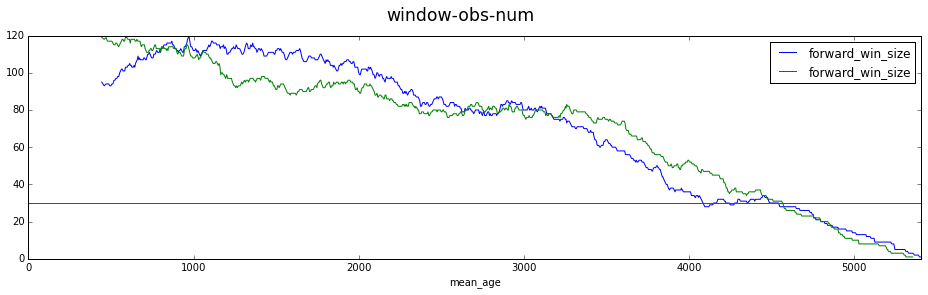

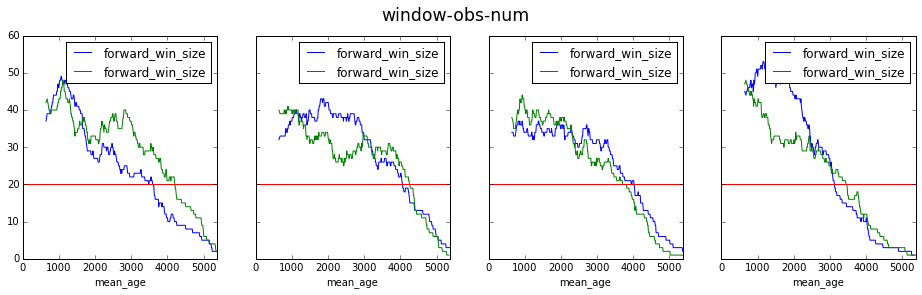

In [43]:
###################################################################
#           Compute runnning window regarding the values          #
###################################################################

# min_window_obs_num = 30

# fig_win_size, axes_win_obs_num = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
# fig_win_size.suptitle("window-obs-num", size='xx-large', y=1.08)
# def get_rolling_window(q):
#     q = q.sort('Age')
#     rolling_df = rollBy(q.multiplicity, q.Age, stars, window=1000)
#     rolling_df.plot('mean_age', 'forward_win_size', ax=axes_win_obs_num)
#     print 'size before filter small windows:', rolling_df.shape[0]
#     rolling_df = rolling_df[rolling_df.forward_win_size > min_window_obs_num]
#     print 'size after filtering small windows:', rolling_df.shape[0]
#     return rolling_df

# print "G"
# rolling_df_g = get_rolling_window(systems_g)
# print "L"
# rolling_df_l = get_rolling_window(systems_l)

# max_age = max(rolling_df_g['mean_age'].max(), rolling_df_l['mean_age'].max())

###################################################################
#           Compute runnning window regardless of values          #
###################################################################

def get_rolling_window(q, window_size, num_ticks, min_window_obs_num, ax):
    q = q.sort('Age')
    rolling_df = roll_window_regardless_values(q.multiplicity, q.Age, stars, window_size=window_size, num_ticks=num_ticks)

    # Plot statistics for window samples num
    rolling_df.plot('mean_age', 'forward_win_size', ax=ax)
    print 'size before filter small windows:', rolling_df.shape[0]
    ax.axhline(y=min_window_obs_num, color='r')
    rolling_df = rolling_df[rolling_df.forward_win_size > min_window_obs_num]
    print 'size after filtering small windows:', rolling_df.shape[0]
    
    return rolling_df



# ###################################################################
# #           Compute for Overall                                   #
# ###################################################################

min_window_obs_num = 30
window_size = 1000
num_ticks = 1000

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
fig.suptitle("window-obs-num", size='xx-large', y=1.00)
print "G"
rolling_df_g = get_rolling_window(systems_g, window_size, num_ticks, min_window_obs_num, ax=ax)
print "L"
rolling_df_l = get_rolling_window(systems_l, window_size, num_ticks, min_window_obs_num, ax=ax)


###################################################################
#           Compute for bins                                      #
###################################################################

min_window_obs_num = 20
window_size = 1500
num_ticks = 400


fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
fig.suptitle("window-obs-num", size='xx-large', y=1.00)
teff_rollings = []
for teff_bin in xrange(len(teff_categories.categories)):
    qg = systems_g[systems_g.teff_bins==teff_bin+1]
    ql = systems_l[systems_l.teff_bins==teff_bin+1]

    ax = axes[teff_bin]
    g = get_rolling_window(qg, window_size, num_ticks, min_window_obs_num, ax=ax)
    l = get_rolling_window(ql, window_size, num_ticks, min_window_obs_num, ax=ax)
    
    teff_rollings.append((g, l))


## Compare frequency, multiplicity - overall

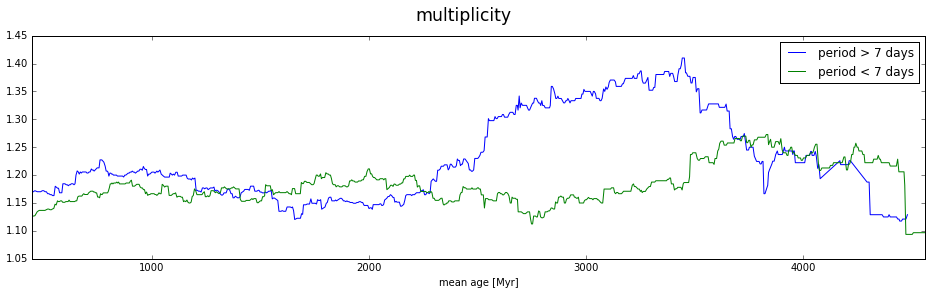

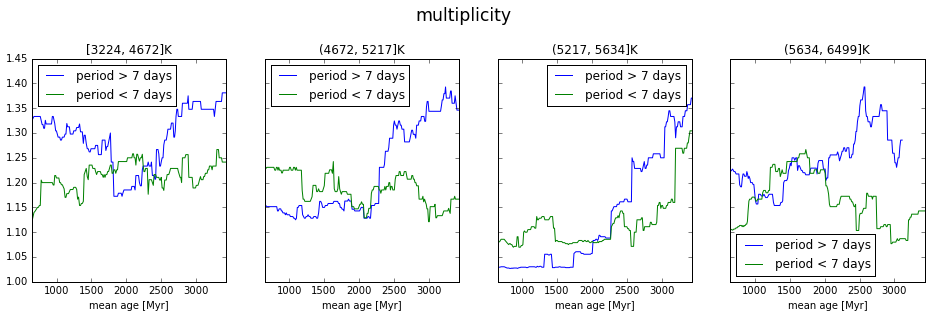

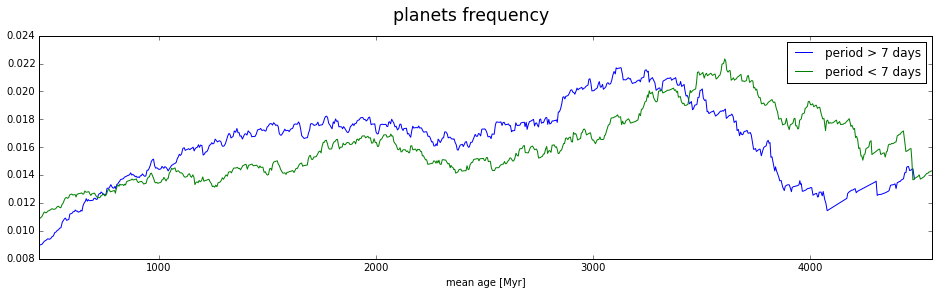

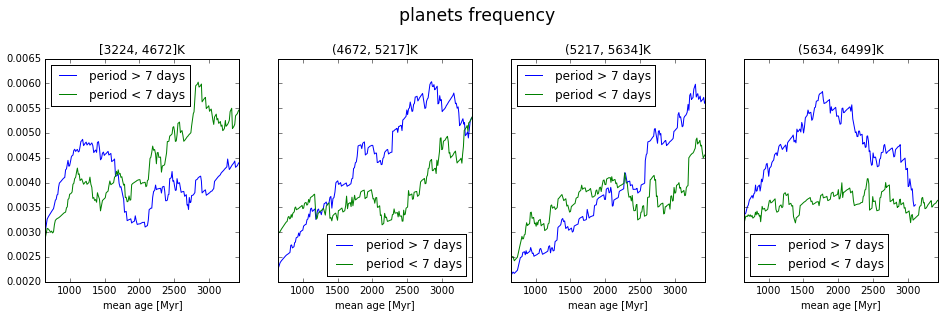

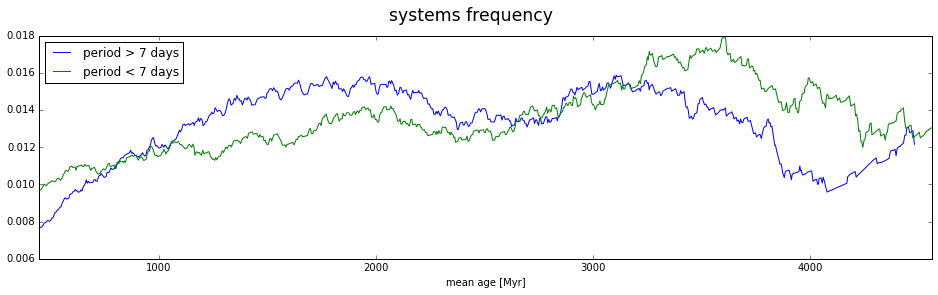

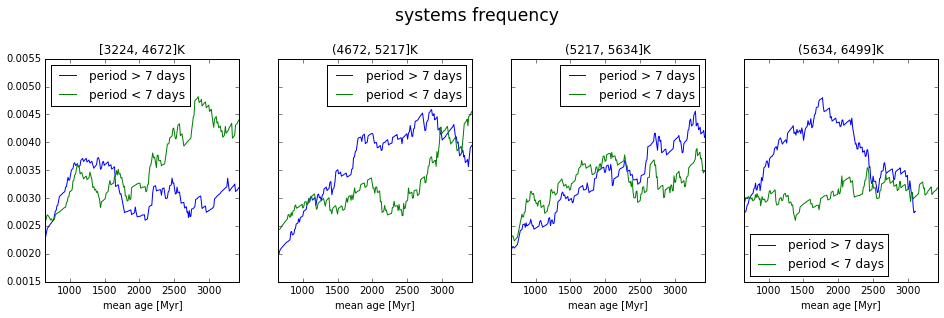

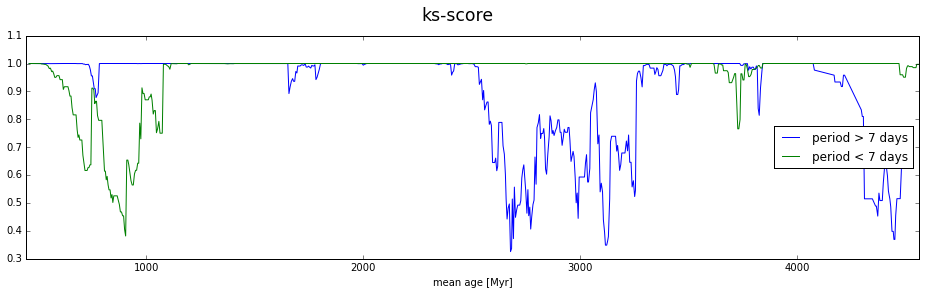

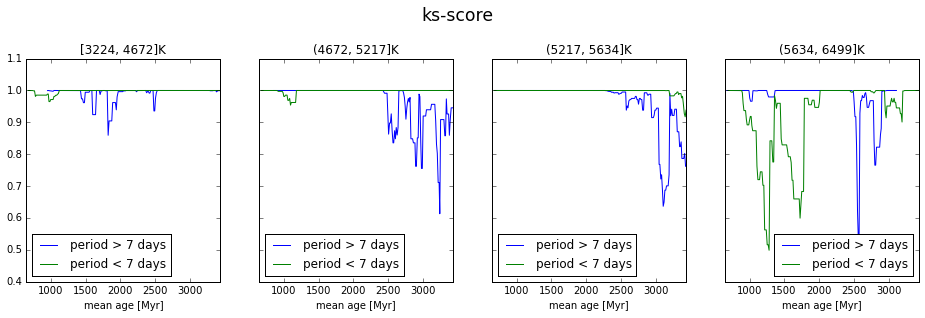

In [46]:
def compare_two_sides(title, g, l, yvalues='mean', **kwargs):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
    g.plot('mean_age', yvalues, ax=ax, label='period > {} days'.format(koi_period_threshold))
    l.plot('mean_age', yvalues, ax=ax, label='period < {} days'.format(koi_period_threshold))
    ax.set_xlabel("mean age [Myr]")
#     # compute ks-score
#     score = ks_2samp(g[yvalues], l[yvalues]).pvalue
#     title = "{:s}\nscore: {}".format(title, score)
    
    fig.suptitle(title, size='xx-large', y=1.00)
    
    
def compare_two_sides_bins(title, teff_rollings, yvalues='mean', **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
    fig.suptitle(title, size='xx-large', y=1.08)

    for teff_bin in xrange(len(teff_categories.categories)):
        ax = axes[teff_bin]
        
        g = teff_rollings[teff_bin][0]
        l = teff_rollings[teff_bin][1]

        g.plot('mean_age', yvalues, ax=ax, label='period > {} days'.format(koi_period_threshold))
        l.plot('mean_age', yvalues, ax=ax, label='period < {} days'.format(koi_period_threshold))

        
        ax.set_title("{}K".format(teff_categories.categories[teff_bin]))
        ax.set_xlabel("mean age [Myr]")


# rolling_df.plot('mean_age', 'ks-score', title='moving window KS score', logy=True)
compare_two_sides('multiplicity', rolling_df_g, rolling_df_l, 'mean')
compare_two_sides_bins('multiplicity', teff_rollings, 'mean')

compare_two_sides('planets frequency', rolling_df_g, rolling_df_l, 'planets-freq')
compare_two_sides_bins('planets frequency', teff_rollings, 'planets-freq')

compare_two_sides('systems frequency', rolling_df_g, rolling_df_l, 'systems-freq')
compare_two_sides_bins('systems frequency', teff_rollings, 'systems-freq')

compare_two_sides('ks-score', rolling_df_g, rolling_df_l, 'ks-score')
compare_two_sides_bins('ks-score', teff_rollings, 'ks-score')
